In [16]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from collections import Counter

plt.rcParams["figure.figsize"] = (8, 5)
sns.set_style("whitegrid")


### Task 3 : Experience Analytics

In [17]:
# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("processed_data.csv")

In [18]:
# -------------------------
# Helper utilities
# -------------------------
def find_column_by_keywords(cols, keywords):
    """Return first column name in cols that contains any of the keywords (case-insensitive)."""
    keys = [k.lower() for k in keywords]
    for c in cols:
        cl = c.lower()
        for k in keys:
            if k in cl:
                return c
    return None

def replace_numeric_missing_with_mean(df, cols):
    for c in cols:
        if c in df.columns:
            if df[c].isnull().any():
                mean_val = df[c].mean()
                df[c].fillna(mean_val, inplace=True)

def replace_categorical_missing_with_mode(df, cols):
    for c in cols:
        if c in df.columns:
            if df[c].isnull().any():
                try:
                    mode_val = df[c].mode().iloc[0]
                except Exception:
                    mode_val = ""
                df[c].fillna(mode_val, inplace=True)

def treat_outliers_zscore_replace_mean(df, cols, z_thresh=3.0):
    """Replace numeric outliers (|z|>z_thresh) with the column mean."""
    for c in cols:
        if c in df.columns:
            col = df[c]
            if col.dtype.kind in 'biufc':  # numeric
                mean = col.mean()
                std = col.std()
                if std == 0 or np.isnan(std):
                    continue
                z = (col - mean) / std
                mask = z.abs() > z_thresh
                if mask.any():
                    df.loc[mask, c] = mean



In [19]:
# -------------------------
# Identify candidate columns
# -------------------------
cols = df.columns.tolist()

# MSISDN / user identifier
msisdn_col = find_column_by_keywords(cols, ["msisdn", "number", "phone"])
if msisdn_col is None:
    raise KeyError("Unable to find MSISDN / user-id column in dataset. Look for 'MSISDN/Number' or similar.")

# TCP retransmission column candidates
tcp_col = find_column_by_keywords(cols, ["tcp", "retrans", "retransmission"])
# RTT column candidates
rtt_col = find_column_by_keywords(cols, ["rtt", "round trip", "round-trip"])
# Throughput column candidates
throughput_col = find_column_by_keywords(cols, ["throughput", "through put", "thrp", "avg throughput", "avg_throughput", "avg_thpt"])
# Handset type
handset_col = find_column_by_keywords(cols, ["handset", "device type", "imei", "handset type"])

### Task 3.1 : Aggregate, per customer

In [20]:
if tcp_col is None:
    # try to find columns with 'tcp' anywhere
    candidates = [c for c in cols if 'tcp' in c.lower()]
    tcp_col = candidates[0] if candidates else None

if rtt_col is None:
    candidates = [c for c in cols if 'rtt' in c.lower()]
    rtt_col = candidates[0] if candidates else None

if throughput_col is None:
    candidates = [c for c in cols if 'through' in c.lower() or 'thput' in c.lower() or 'kbps' in c.lower()]
    throughput_col = candidates[0] if candidates else None

if handset_col is None:
    candidates = [c for c in cols if 'handset' in c.lower() or 'model' in c.lower() or 'type' in c.lower()]
    handset_col = candidates[0] if candidates else None

grouped = df.groupby(msisdn_col)

# Average TCP retransmission per user
if tcp_col is not None:
    avg_tcp = grouped[tcp_col].mean().rename("avg_tcp_retransmission")
else:
    avg_tcp = pd.Series(index=grouped.size().index, dtype=float, name="avg_tcp_retransmission")

# Average RTT per user
if rtt_col is not None:
    avg_rtt = grouped[rtt_col].mean().rename("avg_rtt")
else:
    avg_rtt = pd.Series(index=grouped.size().index, dtype=float, name="avg_rtt")

# Average throughput per user
if throughput_col is not None:
    avg_throughput = grouped[throughput_col].mean().rename("avg_throughput")
else:
    avg_throughput = pd.Series(index=grouped.size().index, dtype=float, name="avg_throughput")
# Handset type per user: use the mode (most frequent handset for that MSISDN)
def mode_series(s):
    try:
        return s.mode().iloc[0]
    except Exception:
        # if no mode available, return NaN
        return np.nan
if handset_col is not None:
    handset_mode = grouped[handset_col].agg(lambda s: mode_series(s)).rename("handset_type")
else:
    handset_mode = pd.Series(index=grouped.size().index, dtype=object, name="handset_type")


# Combine into a single DataFrame per user
user_exp = pd.concat([avg_tcp, avg_rtt, avg_throughput, handset_mode], axis=1).reset_index().rename(columns={msisdn_col: "MSISDN"})
print("\nSample of aggregated experience metrics per user:")
print(user_exp.head())



Sample of aggregated experience metrics per user:
         MSISDN  avg_tcp_retransmission  avg_rtt  avg_throughput  handset_type
0  3.360100e+10                568730.0     46.0            37.0  8.627420e+13
1  3.360100e+10                568730.0     30.0            48.0  3.553261e+13
2  3.360100e+10                568730.0     45.0            48.0  3.561271e+13
3  3.360101e+10                  1066.0     69.0           204.0  3.520491e+13
4  3.360101e+10               4959180.0     57.0         20197.5  3.530681e+13


### Task 3.2 - top, bottom, most frequent 10 values (dataset-wide)

In [21]:
def top_bottom_freq(series, label, n=10):
    # Clean series: dropna
    s = series.dropna()
    # Top n values (largest)
    top_n = s.nlargest(n).values if not s.empty else np.array([])
    # Bottom n values (smallest)
    bottom_n = s.nsmallest(n).values if not s.empty else np.array([])
    # Most frequent n values (value counts)
    most_freq = s.value_counts().head(n)
    print(f"\n=== {label} ===")
    print(f"Top {n} (largest) values:\n", top_n)
    print(f"Bottom {n} (smallest) values:\n", bottom_n)
    print(f"Most frequent {n} values (value:count):\n", most_freq.to_string())

print("\n--- Dataset-wide TCP / RTT / Throughput summaries ---")
if tcp_col is not None:
    top_bottom_freq(df[tcp_col], "TCP retransmission (dataset)")
if rtt_col is not None:
    top_bottom_freq(df[rtt_col], "RTT (dataset)")
if throughput_col is not None:
    top_bottom_freq(df[throughput_col], "Throughput (dataset)")



--- Dataset-wide TCP / RTT / Throughput summaries ---

=== TCP retransmission (dataset) ===
Top 10 (largest) values:
 [4.29442557e+09 4.29138034e+09 4.28987662e+09 4.28948760e+09
 4.28806036e+09 4.27525935e+09 4.26843200e+09 4.25999683e+09
 4.25665002e+09 4.25464383e+09]
Bottom 10 (smallest) values:
 [2. 2. 4. 4. 4. 4. 4. 4. 4. 4.]
Most frequent 10 values (value:count):
 TCP DL Retrans. Vol (Bytes)
568730.0    88147
1330.0        433
2660.0        219
38.0          200
92.0          192
1318.0        156
543.0         133
3990.0        114
76.0          108
5320.0        102

=== RTT (dataset) ===
Top 10 (largest) values:
 [96923. 64640. 55811. 54847. 26971. 26250. 25873. 25602. 25374. 24733.]
Bottom 10 (smallest) values:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
Most frequent 10 values (value:count):
 Avg RTT DL (ms)
45.0    29907
28.0     3553
27.0     3380
34.0     3296
35.0     2892
37.0     2718
36.0     2645
38.0     2547
29.0     2498
26.0     2488

=== Throughput (dataset) ===
Top 10 (

### Task 3.3 - Distribution & averages per handset type

In [22]:
if handset_col is not None:
    # ensure handset_type is string
    user_exp["handset_type"] = user_exp["handset_type"].astype(str).fillna("Unknown")
    # Average throughput distribution per handset
    throughput_by_handset = user_exp.groupby("handset_type")["avg_throughput"].agg(["count", "mean", "median", "std"])
    tcp_by_handset = user_exp.groupby("handset_type")["avg_tcp_retransmission"].agg(["count", "mean", "median", "std"])
    # Sort by mean throughput descending for interpretability
    throughput_by_handset = throughput_by_handset.sort_values("mean", ascending=False)
    tcp_by_handset = tcp_by_handset.sort_values("mean", ascending=False)

    print("\nTop handset types by average throughput (sample 10):")
    print(throughput_by_handset.head(10))
    print("\nHandset types by average TCP retransmission (sample 10):")
    print(tcp_by_handset.head(10))



Top handset types by average throughput (sample 10):
                  count      mean    median  std
handset_type                                    
86948003611112.0      1  264448.0  264448.0  NaN
35729209556674.0      1  245347.0  245347.0  NaN
35862409644464.0      1  236507.0  236507.0  NaN
86376903420232.0      1  230084.0  230084.0  NaN
35285109090614.0      1  225035.0  225035.0  NaN
86376903247252.0      1  223533.0  223533.0  NaN
35304709479615.0      1  223224.0  223224.0  NaN
35155809209832.0      1  218742.0  218742.0  NaN
86705204818551.0      1  211835.0  211835.0  NaN
86376903480806.0      1  209672.0  209672.0  NaN

Handset types by average TCP retransmission (sample 10):
                  count          mean        median  std
handset_type                                            
86376903295316.0      1  4.289488e+09  4.289488e+09  NaN
86376903399992.0      1  4.288060e+09  4.288060e+09  NaN
86376903509744.0      1  4.268432e+09  4.268432e+09  NaN
86376903489451.

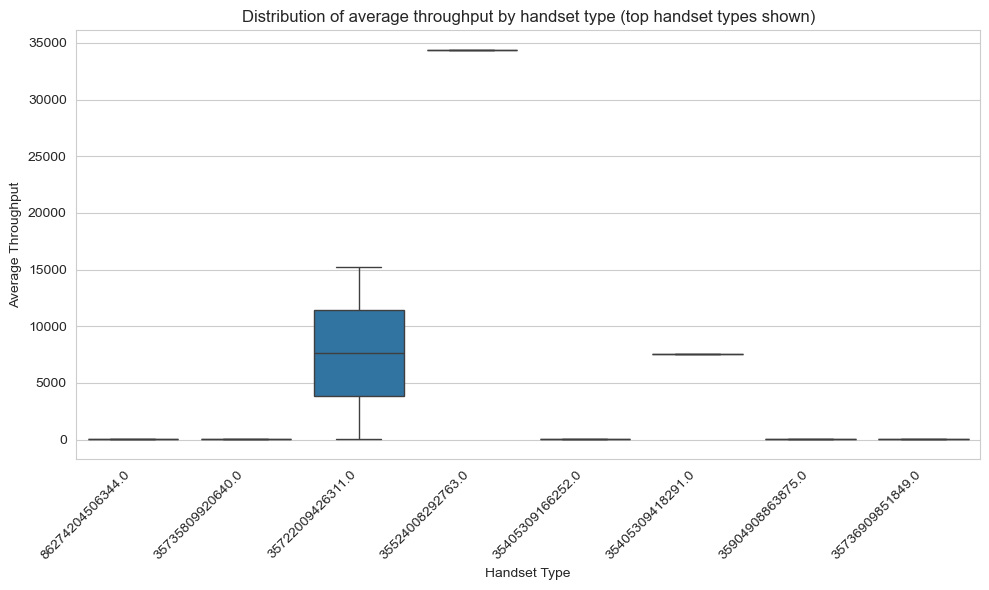

In [23]:
 # Visualize distribution of avg_throughput per handset (top N handset types by count)
top_handsets_by_count = user_exp["handset_type"].value_counts().head(8).index.tolist()
plt.figure(figsize=(10,6))
sns.boxplot(x="handset_type", y="avg_throughput", data=user_exp[user_exp["handset_type"].isin(top_handsets_by_count)])
plt.title("Distribution of average throughput by handset type (top handset types shown)")
plt.ylabel("Average Throughput")
plt.xlabel("Handset Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

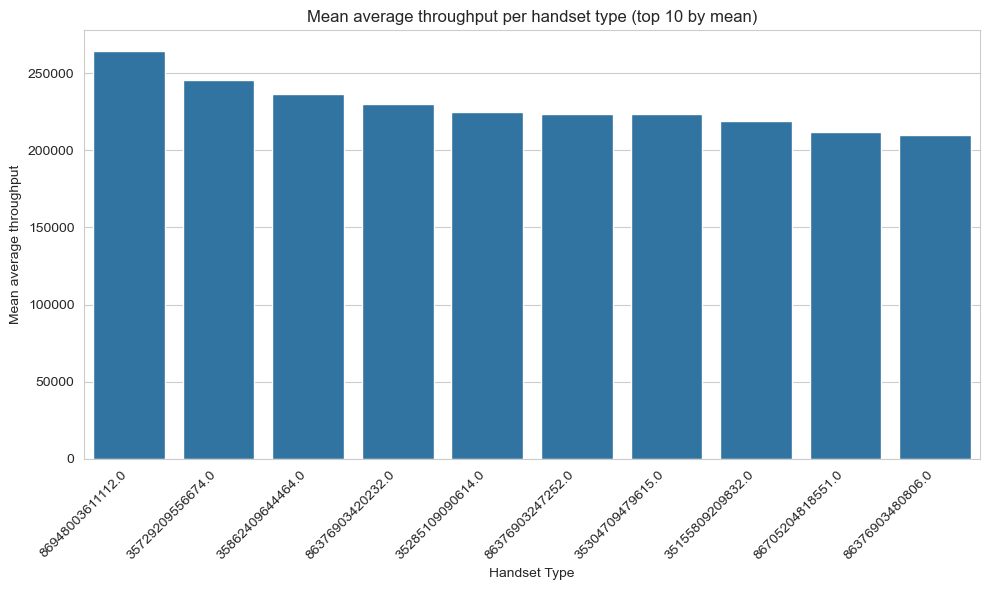

In [24]:
 # Visualize average TCP retransmission per handset (bar chart top handset types by count)
plt.figure(figsize=(10,6))
sns.barplot(x=throughput_by_handset.head(10).index, y=throughput_by_handset.head(10)["mean"])
plt.title("Mean average throughput per handset type (top 10 by mean)")
plt.ylabel("Mean average throughput")
plt.xlabel("Handset Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


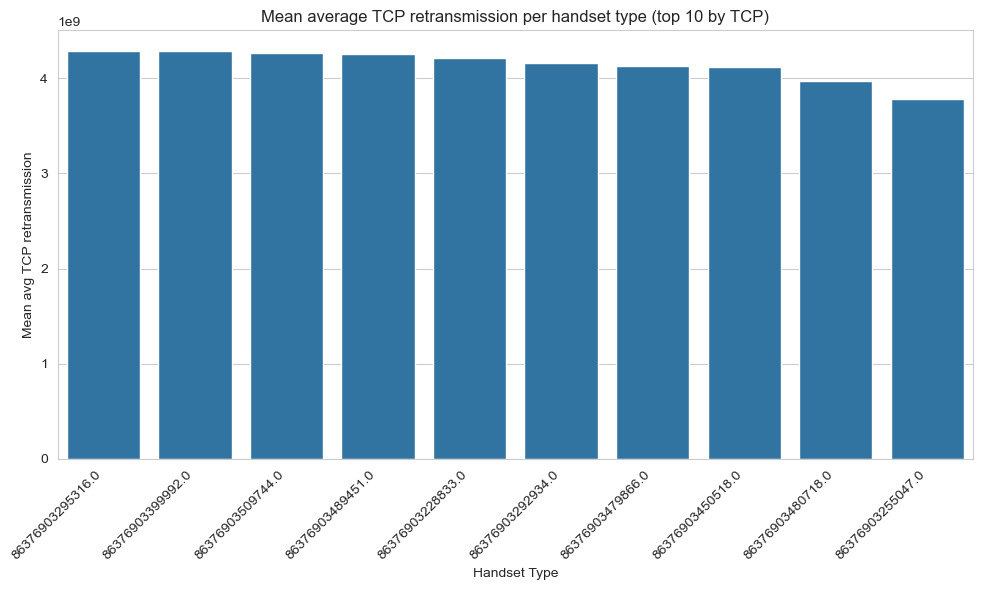

In [25]:
# Barplot TCP retransmission
plt.figure(figsize=(10,6))
sns.barplot(x=tcp_by_handset.head(10).index, y=tcp_by_handset.head(10)["mean"])
plt.title("Mean average TCP retransmission per handset type (top 10 by TCP)")
plt.ylabel("Mean avg TCP retransmission")
plt.xlabel("Handset Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Interpretations 
Interpretation - throughput per handset:"
- Handsets with higher mean average throughput likely represent newer or higher-end devices or users on better network segments."
- Handsets with low throughput may be older devices, handset misconfigurations, or users in poor radio conditions."
- Interpretation - TCP retransmission per handset:"
- Higher average TCP retransmission suggests poorer link reliability (packet loss, retransmissions) for those handsets/users."
- If a handset shows systematically high retransmission but normal throughput, it may indicate TCP tuning or cellular stack differences."


### KMeans clustering (k=3) on experience metrics

In [26]:
# Prepare experience features: avg_tcp_retransmission, avg_rtt, avg_throughput
features = ["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]
X = user_exp[features].values

# Standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
user_exp["experience_cluster_k3"] = kmeans.fit_predict(X_scaled)

# Compute cluster centers (in original scale)
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=features)
centers_df["cluster"] = centers_df.index
print("\nKMeans (k=3) cluster centers (original scale):")
print(centers_df)

# Assign simple textual description for each cluster based on center relative to global means
global_means = user_exp[features].mean()
desc = {}
for idx, row in centers_df.iterrows():
    parts = []
    for f in features:
        val = row[f]
        gm = global_means[f]
        if f == "avg_rtt":
            # for RTT and TCP, lower is better
            if val <= gm * 0.8:
                parts.append(f"{f}: low (better)")
            elif val >= gm * 1.2:
                parts.append(f"{f}: high (worse)")
            else:
                parts.append(f"{f}: medium")
        else:
            # for throughput higher is better; for tcp retransmission lower is better
            if f == "avg_throughput":
                if val >= gm * 1.2:
                    parts.append(f"{f}: high (better)")
                elif val <= gm * 0.8:
                    parts.append(f"{f}: low (worse)")
                else:
                    parts.append(f"{f}: medium")
            else:  # avg_tcp_retransmission (lower better)
                if val <= gm * 0.8:
                    parts.append(f"{f}: low (better)")
                elif val >= gm * 1.2:
                    parts.append(f"{f}: high (worse)")
                else:
                    parts.append(f"{f}: medium")
    desc[row['cluster']] = "; ".join(parts)

print("\nCluster descriptions (automatic, interpret):")
for cl, txt in desc.items():
    print(f"Cluster {cl}: {txt}")

# Show cluster counts
print("\nCluster counts:")
print(user_exp["experience_cluster_k3"].value_counts())





KMeans (k=3) cluster centers (original scale):
   avg_tcp_retransmission     avg_rtt  avg_throughput  cluster
0            1.578341e+06  111.059386     3794.081911        0
1            2.224267e+09  104.547799    62838.408386        1
2            1.793797e+07   76.458151    49139.454180        2

Cluster descriptions (automatic, interpret):
Cluster 0.0: avg_tcp_retransmission: low (better); avg_rtt: medium; avg_throughput: low (worse)
Cluster 1.0: avg_tcp_retransmission: high (worse); avg_rtt: medium; avg_throughput: high (better)
Cluster 2.0: avg_tcp_retransmission: high (worse); avg_rtt: low (better); avg_throughput: high (better)

Cluster counts:
experience_cluster_k3
0    88429
2    18268
1      159
Name: count, dtype: int64


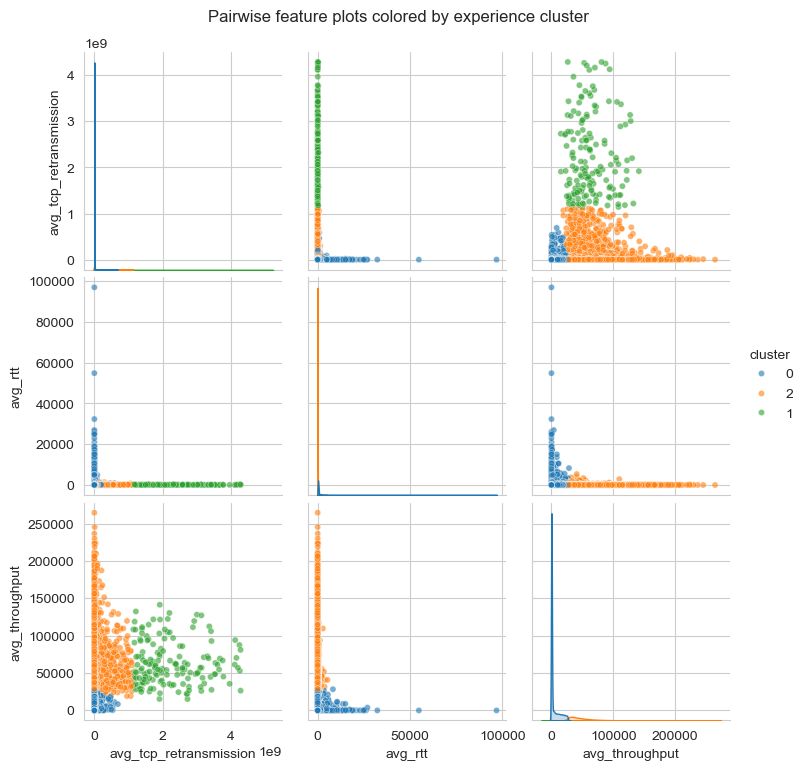

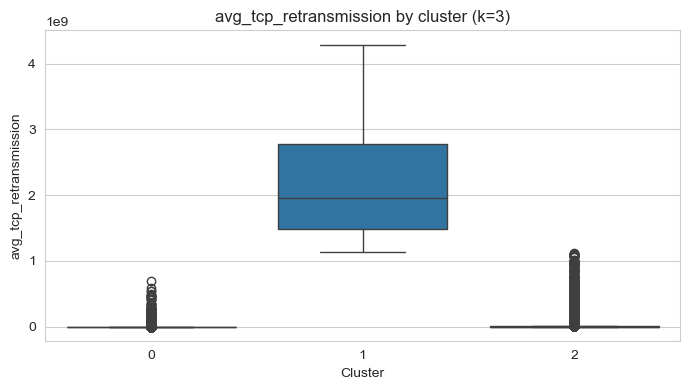

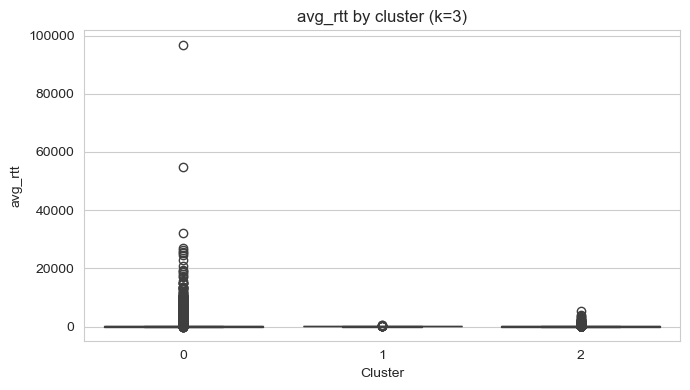

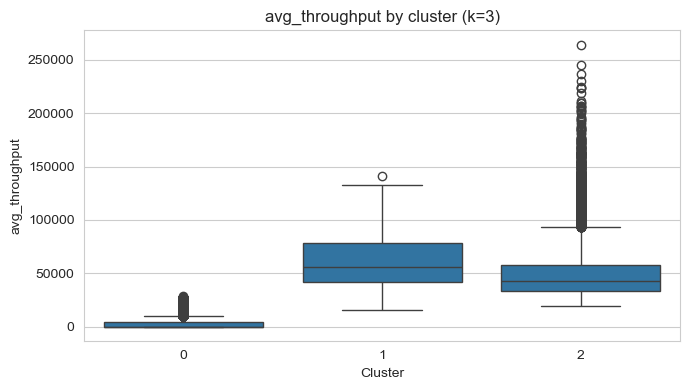

In [27]:
# Visualize clusters in pairwise scatter plots
# pairwise plot of features colored by cluster
pair_df = user_exp[features + ["experience_cluster_k3"]].copy()
pair_df["cluster"] = pair_df["experience_cluster_k3"].astype(str)
sns.pairplot(pair_df, hue="cluster", vars=features, diag_kind="kde", plot_kws={"s": 20, "alpha": 0.6})
plt.suptitle("Pairwise feature plots colored by experience cluster", y=1.02)
plt.show()

# Boxplots per feature by cluster
for f in features:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="experience_cluster_k3", y=f, data=user_exp)
    plt.title(f"{f} by cluster (k=3)")
    plt.xlabel("Cluster")
    plt.tight_layout()
    plt.show()

In [28]:
# Provide compact descriptions derived from desc and centers
for cl in centers_df['cluster']:
    center = centers_df[centers_df['cluster'] == cl].iloc[0]
    # determine label heuristically
    tcp = center["avg_tcp_retransmission"]
    rtt = center["avg_rtt"]
    thr = center["avg_throughput"]
    # scoring: higher throughput & lower tcp & lower rtt -> best experience
    score = ( (thr / (global_means["avg_throughput"] + 1e-9)) 
             + (global_means["avg_tcp_retransmission"] / (tcp + 1e-9))
             + (global_means["avg_rtt"] / (rtt + 1e-9)) )
    # translate to label
    if score >= 3.0:
        label = "Good experience (high throughput, low retrans/Round-Trip)"
    elif score >= 2.0:
        label = "Average experience (medium metrics)"
    else:
        label = "Poor experience (low throughput and/or high retrans/Round-Trip)"
    print(f"Cluster {cl}: {label} -- center metrics: tcp={tcp:.3f}, rtt={rtt:.3f}, throughput={thr:.3f}")

Cluster 0: Good experience (high throughput, low retrans/Round-Trip) -- center metrics: tcp=1578341.154, rtt=111.059, throughput=3794.082
Cluster 1: Good experience (high throughput, low retrans/Round-Trip) -- center metrics: tcp=2224266504.702, rtt=104.548, throughput=62838.408
Cluster 2: Good experience (high throughput, low retrans/Round-Trip) -- center metrics: tcp=17937968.453, rtt=76.458, throughput=49139.454


In [29]:
# Save DataFrame into CSV back for next use
df.to_csv("processed_data.csv", index=False)

print("✅ DataFrame saved as processed_data.csv for next use")

✅ DataFrame saved as processed_data.csv for next use
